In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import Levenshtein as lev

import matplotlib.pyplot as plt
from arion.utils import generate_db, peakset2ppm, Colors

In [4]:
data_dir = '/media/shared/arion_data/metabolites'

In [5]:
filled = pd.read_csv('filled.csv').iloc[:, 1:]
features = pd.read_csv('features.csv').iloc[:, 1:]
features.shape

(16, 547)

In [6]:
import glob
import xml.etree.ElementTree as ET
import csv

data_dir = '/media/shared/arion_data/metabolites'
xml_file = 'simulation_1/spin_simulation.xml'
cutoff = 0.001

# load all GISSMO metabolite ids
peaks = []
met_idx = 0
names = {}
for met_idx, d in enumerate(glob.glob(f'{data_dir}/bmse*')):
    metabolite_id = d.split('/')[-1]

    tree = ET.parse(f'{d}/{xml_file}')
    root = tree.getroot()
    names[root.find('ID').text] = root.find('name').text

# load all potential metabolites from Hamid
hamid_met_names = []
with open("names_from_hamid.csv") as f:
    csvfile = csv.reader(f)
    next(csvfile)
    for line in csvfile:
        hamid_met_names.append([l.strip() for l in line])
        
# create an overlap set from the two above
matched_count = 0
unmatched_count = 0

matched_set = set()
for hamid_met_name_set in hamid_met_names:
    matches = []
    for n in hamid_met_name_set:
        scores = [(n, lev.jaro(n.lower(), m.lower()), (i, m)) for i, m in names.items()]
        matches.append(max(scores, key=lambda a: a[1]))
    
    if any([abs(m[1] - 1) < 0.000001 for m in matches]):
        matched_count += 1
        maxv = max(matches, key=lambda a: a[1])
        matched_set.add(maxv[2][0])
    else:
        orig = [i[0] for i in matches]
        suggestions = [f'{i[2][1]} <{i[2][0]}>' for i in matches]
        
        unmatched_count += 1
        
matched_set.update(['bmse000208', 'bmse000161', 'bmse000373', 'bmse000092', 'bmse000142', 'bmse000182'])

print(f"matched {matched_count} | unmatched {unmatched_count}")

matched 68 | unmatched 46


In [6]:
# MAX_CLIQUES = 100000
# PEARSON_CORRELATION_THRESHOLDS = np.arange(.8, .9, .05)
# MINIMUM_PERCENTAGE_OF_PEAKS_MATCHED_THRESHOLDS = np.arange(.1, .2, .1)

# results = []
# peak_db = generate_db(data_dir)
# for pearson_thresh in PEARSON_CORRELATION_THRESHOLDS:
#     for match_thresh in MINIMUM_PERCENTAGE_OF_PEAKS_MATCHED_THRESHOLDS:

#         corr_mat = features.corr('spearman')

#         g = nx.Graph(corr_mat > pearson_thresh)
#         cliqs = []

#         for idx, cliq in enumerate(nx.find_cliques(g)):
#             if idx > MAX_CLIQUES:
#                 raise Exception(f"More than {MAX_CLIQUES} cliques found")
#                 break
#             cliqs.append(cliq)
#         print(f"found {len(cliqs)} cliques")

#         found = False
#         identified_metabolites = {}
#         for idx, cliq in enumerate(cliqs):
#             res = peak_db.query_n(peakset2ppm(cliq, filled))
#             for qs in res:
#                 if qs['score'] >= match_thresh and len(peak_db.metabolite_peaks[qs['metabolite_id']]) > 1 and len(qs['missing']) < 2:
#                     if qs['metabolite_id'] not in identified_metabolites:
#                         identified_metabolites[qs['metabolite_id']] = []

#                     identified_metabolites[qs['metabolite_id']].append({
#                         "id": idx, 
#                         "cliq": cliq, 
#                         "query_results": qs
#                     })

#         max_scored_metabolites = []
#         for met_id in identified_metabolites.keys():
#             metabolite_max_score = max(identified_metabolites[met_id], key=lambda m: m['query_results']['score'])

#             max_scored_metabolites.append(metabolite_max_score)

#         results.append({
#             'pearson_thresh': pearson_thresh,
#             'match_thresh': match_thresh, 
#             'sorted_metabolites': sorted(max_scored_metabolites, key=lambda m: -m['query_results']['score'])
#         })

In [7]:
import json

with open("../data/grid_search_results.json") as f:
    results = json.load(f)

met_ranks = {}
for res in results:
    for rank, met in enumerate(res['sorted_metabolites']):
        met_id = met['query_results']['metabolite_id']
        if met_id not in met_ranks:
            met_ranks[met_id] = []
        
        met['rank'] = rank+1
        met_ranks[met_id].append(met)

In [8]:
maxl = len(max(list(met_ranks.values()), key= lambda l: len(l)))
max_rank = max(list(met_ranks.values()), key= lambda l: max(l, key= lambda l1: l1['rank'])['rank'])[0]['rank']

mets = []
for met_id, met in met_ranks.items():
    met_rank = ((maxl - len(met)) * max_rank + sum([i['rank'] for i in met])) / maxl
    mets.append({
        'rank_avg': met_rank,
        'met': met,
        'met_id': met_id
    })

In [9]:
print(f'max_rank: {max_rank}')
final_res = []
for met in sorted(mets, key=lambda m: m['rank_avg']):
    if met['met_id'] in matched_set:
        final_res.append((met['met_id'], names[met['met_id']]))
        print(f" {met['met_id']} -- average_rank: "
              f"{met['rank_avg']:5.1f} -- "
              f"max_score: {max(met['met'], key=lambda m: m['query_results']['score'])['query_results']['score']:.2f} -- "
              f"{names[met['met_id']]}"
             )

max_rank: 192
 bmse000069 -- average_rank:   4.8 -- max_score: 1.00 -- Betaine
 bmse000208 -- average_rank:   4.9 -- max_score: 1.00 -- L-(+) Lactic acid
 bmse000076 -- average_rank:   4.9 -- max_score: 1.00 -- Citrate
 bmse000206 -- average_rank:  18.6 -- max_score: 0.75 -- Caffeine
 bmse000155 -- average_rank:  23.3 -- max_score: 1.00 -- Creatinine
 bmse000160 -- average_rank:  24.6 -- max_score: 0.50 -- Sarcosine
 bmse000078 -- average_rank:  31.7 -- max_score: 0.50 -- Creatine
 bmse000161 -- average_rank:  51.8 -- max_score: 0.94 -- 3-Hydroxybutyrate
 bmse000863 -- average_rank:  60.2 -- max_score: 0.86 -- Taurine
 bmse000028 -- average_rank:  78.4 -- max_score: 0.33 -- L-Alanine
 bmse000614 -- average_rank:  80.2 -- max_score: 0.17 -- Vanillic acid
 bmse000398 -- average_rank:  80.7 -- max_score: 0.17 -- Methylmalonic acid
 bmse000439 -- average_rank:  81.7 -- max_score: 0.44 -- Isobutyric acid
 bmse000049 -- average_rank:  82.7 -- max_score: 0.20 -- L-Threonine
 bmse000458 -- ave

In [10]:
peak_db = generate_db(data_dir)

In [11]:
raw_day0 = pd.read_csv('../data/source_data/AVM_day0_spectra.csv', delimiter='\t').iloc[:, :-1]

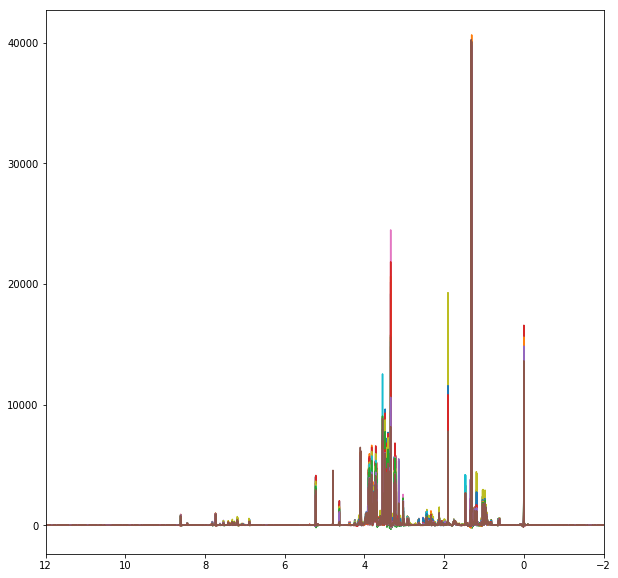

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(raw_day0.iloc[:, 0][::-1], raw_day0.iloc[:, 1:][::-1]);
plt.xlim(12, -2);

In [1]:
# identify a max amplitude value
width = 0.0075
same_ymax = True
# width = 0.1

for found_met in final_res[1]:
    met_peaks = peak_db.metabolite_peaks[found_met[0]]
    peak_max = max(met_peaks, key=lambda x: x.amp).ppm
    idx1 = np.abs(raw_day0.iloc[:, 0] - peak_max + 0.0075).idxmin()
    idx2 = np.abs(raw_day0.iloc[:, 0] - peak_max - 0.0075).idxmin()
    
    # average of top 20 peaks is our estimate of max_amp
    max_amp = raw_day0.iloc[idx1:idx2].values.flatten()[raw_day0.iloc[idx1:idx2].values.flatten().argsort()[::-1][:15]].mean()

    s = len(met_peaks)
    rows = s // 3
    rows = rows if s % 3 == 0 else rows + 1

    f, axl = plt.subplots(nrows=rows, ncols=3, figsize=(15, 5 * rows))
    f.suptitle(found_met[1])

    overall_ymax = 0
    for i, peak in enumerate(met_peaks):
        ax = axl.flatten()[i]
        center = peak.ppm

        ax.plot(raw_day0.iloc[:, 0][::-1], raw_day0.iloc[:, 1:][::-1], 'r', alpha=0.3);
        
        for m in met_peaks:
            ax.axvline(x=m.ppm, linestyle='--', color='b', alpha=0.3)
        ax.axvline(x=center, linestyle='--', color='m')
        
        ax.axhline(y=peak.amp * max_amp, linestyle='--', color='b')

        ax.set_title(f'{peak.id} -- {peak.amp:.4f}')
        ax.set_xlim(center + width, center - width)

        idx1 = np.abs(raw_day0.iloc[:, 0] - center + width).idxmin()
        idx2 = np.abs(raw_day0.iloc[:, 0] - center - width).idxmin()
        ymax = raw_day0.iloc[idx1:idx2].values.max() * 1.01

        if ymax > overall_ymax:
            overall_ymax = ymax
        ax.set_ylim(0, ymax)

    if same_ymax:
        for i, peak in enumerate(met_peaks):
            ax = axl.flatten()[i]
            ax.set_ylim(0, overall_ymax)

NameError: name 'final_res' is not defined